<a href="https://colab.research.google.com/github/pankhurivanjani/Extended_plant_disease_detecttion/blob/WIP-pankhuri/plant_docs_train_efficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [52]:
!pip install efficientnet_pytorch

In [53]:
# dependencies
import cv2
import os
from pathlib import Path
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
from torchvision import datasets, transforms, models 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet


In [54]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the data and organizing it 
root_dir = 'drive/My Drive/'
data_dir = root_dir + 'plant-disease-dataset/PlantDoc-Dataset/train'
nthreads = 4
batch_size = 8

In [55]:
transform_train = transforms.Compose([transforms.Resize((224,224)), #prev 255
                                transforms.CenterCrop(299), #prev 224
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])
                               ])
transform_test = transforms.Compose([transforms.Resize((224,224)), #prev 255
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])
                               ])

In [56]:

class MyLazyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        y = dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(dataset)

In [57]:
dataset = datasets.ImageFolder(data_dir)

traindataset = MyLazyDataset(dataset,transform_train)
valdataset = MyLazyDataset(dataset,transform_test)

# Create the index splits for training, validation and test
train_size = 0.8
num_data = len(dataset)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(train_size * num_data))
train_idx, valid_idx = indices[:split], indices[ split:]

traindata = torch.utils.data.Subset(traindataset, indices=train_idx)
valdata = torch.utils.data.Subset(valdataset, indices=valid_idx)

trainLoader = torch.utils.data.DataLoader(traindata, batch_size=batch_size)
                                              
valLoader = torch.utils.data.DataLoader(valdata, batch_size=batch_size)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape: (8, 3, 299, 299) Batch size: 8
label size: 17


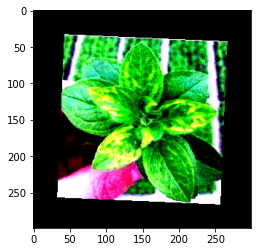

In [58]:
images, labels = next(iter(trainLoader))
images = images.numpy()

print("Shape:", images.shape, "Batch size:", len(images))
plt.imshow(np.transpose(images[0], (1,2,0)))
print("label size:" , labels[4].numpy())

In [59]:
#Downloading and building the classifier

#model = models.resnext101_32x8d(pretrained=True)
model = EfficientNet.from_pretrained('efficientnet-b7')
model

Loaded pretrained weights for efficientnet-b7


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_siz

In [60]:
### Freeze parameters
for param in model.parameters():
  param.requires_grad = False

In [75]:

### Defining new classification layer (Feed-forward network as a classifier using ReLU activations)

classifier = nn.Sequential(nn.Linear(2560,1280),
                   nn.ReLU(),
                   nn.Dropout(0.3),
                   nn.Linear(1280,640),
                   nn.ReLU(),
                   nn.Dropout(0.3),
                   nn.Linear(640,28),
                   nn.LogSoftmax(dim=1))
model.fc = classifier

In [76]:
from torch import optim
### Loss of optimizers definition
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001)
##using adaptive learning rate
##from torch.optim import lr_scheduler
##exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_siz

In [77]:
## Training and Validation
epochs = 30
train_losses, valid_losses = [], []
valid_loss_min = np.Inf

for e in range(epochs):
  running_loss = 0
  for images, labels in trainLoader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    logps = model.forward(images)
    loss = criterion(logps, labels)
    #optimizer.zero_grad()
    loss.backward(create_graph=True)
    #torch.autograd.grad(logps, model.fc.parameters())
    optimizer.step()
    running_loss += loss.item()

  else: ##if in valid_loader
    valid_loss = 0
    accuracy = 0
    with torch.no_grad():
      model.eval()
      for images, labels in valLoader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        valid_loss += criterion(log_ps, labels)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainLoader))
    valid_losses.append(valid_loss/len(valLoader))
    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Validation Loss: {:.3f}.. ".format(valid_losses[-1]),
          "Validation Accuracy: {:.3f}".format(accuracy/len(valLoader)))
    if valid_losses[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_losses[-1]))
        torch.save(model.state_dict(), 'model_incept.pt')
        valid_loss_min = valid_losses[-1]

RuntimeError: ignored

In [ ]:
### Training and validation loss graph
plt.plot(train_losses, label = 'Training loss')
plt.plot(valid_losses, label = 'Validation loss')
plt.legend(frameon = False)

In [ ]:
### Load the model state with lowest validation¶
model.load_state_dict(torch.load('model_incept.pt'))

In [ ]:
test_dir = root_dir + '/plant-disease-dataset/PlantDoc-Dataset/test'
testset = datasets.ImageFolder(test_dir, transform=transform_test)
num_test = len(testset)
#indices = list(range(num_test))
#x = int(np.floor(num_test))

#test_idx = indices[:x]
#test_sampler = SubsetRandomSampler(test_idx)
#test_loader = torch.utils.data.DataLoader(testset, batch_size=1, sampler=test_sampler)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1)

In [ ]:
### Test the trained network
img, labs = next(iter(test_loader))
cls_len = len(test_loader)
test_loss = 0.0
accuracy = 0
model.eval()

for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    logs_ps = model(data)
    test_loss += criterion(logs_ps, target)
    ps = torch.exp(logs_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == target.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor))
print("Test loss: {:.3f}.. \t Test Accuracy: {:.3f}".format(test_loss/len(test_loader), accuracy/len(test_loader)))